In [1]:
import pandas as pd
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import tiktoken

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_comments_folder = Path("/Users/chengbai/ml/dataset/flickr30k_images/")
img_comments_file = img_comments_folder / "results.csv" # /Users/chengbai/ml/dataset/flickr30k_images/results.csv
imgs_folder = img_comments_folder / "flickr30k_images"  # /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images

list(imgs_folder.glob("*.jpg"))[:2]

[PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/2609797461.jpg'),
 PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/1788892671.jpg')]

In [3]:
# The current `results.csv` file is using "| " to seperate 3 columns. 
# For the pd.read_csv, the `sep` here is given as a regular expression. 
df = pd.read_csv(img_comments_file, sep="|", index_col=False)
df = df.astype({'image_name': 'str', 'comment_number': int, 'comment': str})
df1 = df[0: 1]
list(df1["image_name"]), df1["image_name"][0]


(['1000092795.jpg'], '1000092795.jpg')

In [4]:
class Config:
    # Image
    img_w_size = 500
    img_h_size = 500

    # Text
    max_text_len = 50

def load_img_tensor(config: Config, img_file_path: Path) -> torch.tensor:
    # Load image from file
    img = Image.open(img_file_path)
    
    # Convert to tensor
    convert_tensor = transforms.ToTensor()
    img_tensor = convert_tensor(img)

    # resize base on config
    resize = transforms.Resize(size=(config.img_h_size, config.img_w_size))
    img_tensor = resize(img_tensor)
    return img_tensor

# Create Dataset 
class ImgCommentDataset(Dataset):
    def __init__(self, config: Config,  img_comments_folder: Path, train_test_split: str = "train", train_test_split_portion: float = 0.8):
        self.config = config
        self.img_commments_folder = img_comments_folder
        self.img_comments_file = img_comments_folder / "results.csv"
        self.imgs_folder = img_comments_folder / "flickr30k_images"
        
        self.train_test_split = train_test_split
        self.train_test_split_portion = train_test_split_portion

        # The current `results.csv` file is using "| " to seperate 3 columns. 
        # For the pd.read_csv, the `sep` here is given as a regular expression. 
        df = pd.read_csv(self.img_comments_file, sep="|")
        train_split_len = int(len(df)*self.train_test_split_portion)
        if self.train_test_split == "train":
            self.img_comments_df = df[:train_split_len]
        else:
            self.img_comments_df = df[train_split_len:]
        
        self.text_encoder = tiktoken.encoding_for_model("gpt-4o")
            
    def __len__(self):
        return len(self.img_comments_df)
    
    def __getitem__(self, idx:int):
        print(f"idx: {idx}")
        row_df = self.img_comments_df[idx: idx+1]
        image_name = str(list(row_df["image_name"])[0])
        assert (self.imgs_folder/image_name).is_file(), f"cannot find file: {self.img_commments_folder/image_name}"

        comment_number = int(list(row_df["comment_number"])[0])
        comment = str(list(row_df["comment"])[0])
        comment_encoding = self.text_encoder.encode(comment)
        if len(comment_encoding) > self.config.max_text_len:
            comment_encoding = comment_encoding[:self.config.max_text_len]
        else:
            # TODO: review append `<|im_end|>` - 200265 logic
            comment_encoding = comment_encoding + [200265 for _ in range(self.config.max_text_len - len(comment_encoding))]
        assert len(comment_encoding) == self.config.max_text_len
        comment_encoding = torch.tensor(comment_encoding, dtype=torch.int)
        
        # return load_img_tensor(self.imgs_folder/image_name), comment_number, comment, comment_encoding
        img_tensor = load_img_tensor(self.config, self.imgs_folder/image_name)

        return img_tensor, comment_encoding
        


In [5]:
config = Config()

train_dataset = ImgCommentDataset(config, img_comments_folder, train_test_split="train", train_test_split_portion=0.8)
test_dataset = ImgCommentDataset(config, img_comments_folder, train_test_split="test", train_test_split_portion=0.8)
print(len(train_dataset), len(test_dataset))

127132 31783


idx: 0


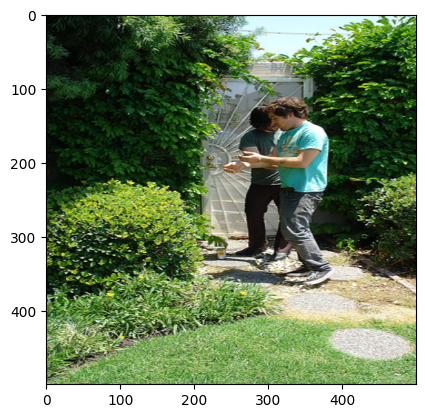

In [10]:
img_tensor, comment_encoding = train_dataset[0]
plt.imshow(img_tensor.permute(1, 2, 0)) # C x H x W => H x W x C

In [8]:
# Data Loader
from torch.utils.data import DataLoader

BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# for batch_data in train_dataloader:
#     print(train_dataloader)
#     break
batch_img_tensors, batch_text_encodings = next(iter(train_dataloader))
print(f"batch_img_tensors: {batch_img_tensors.size()}")
print(f"batch_text_encodings: {batch_text_encodings.size()}")

idx: 2400
idx: 41022
batch_img_tensors: torch.Size([2, 3, 500, 500])
batch_text_encodings: torch.Size([2, 50])


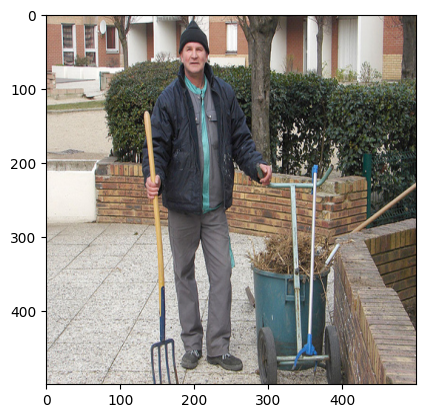

In [11]:
plt.imshow(batch_img_tensors[0].permute(1, 2, 0)) # C x H x W => H x W x C